In [2]:
%%capture
!pip install -U git+https://github.com/dcruzf/anfis-toolbox.git@21-improve-documentation-and-implement-github-actions-for-ci

# Time Series

## 1. Generating Synthetic Time Series Data

To create a simple univariate time series for experimentation, we generated synthetic data using a sinusoidal signal with added Gaussian noise. The following code snippet illustrates this process:

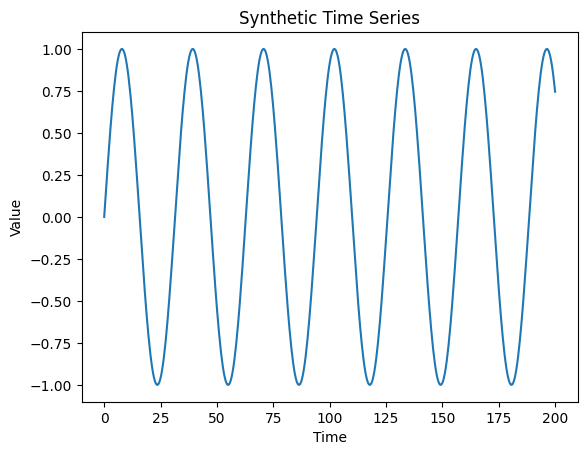

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a time vector
t = np.linspace(0, 200, 500)

# Create a sinusoidal series with small random noise
series = np.sin(0.2 * t) + np.random.normal(0, 10, len(t)) * 0.0

# Visualize the time series
plt.plot(t, series)
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Synthetic Time Series")
plt.show()

This produces a smooth oscillating pattern that simulates a noisy periodic signal.
Such synthetic datasets are useful for testing time series forecasting models under controlled conditions.

## 2. Creating Supervised Samples Using Rolling Windows

To convert the time series into a supervised learning format, we applied a **rolling window** (or *sliding window*) of fixed length.
Each input sample consists of the previous ( k = 5 ) observations, and the target corresponds to the **next scalar value** in the sequence.

Formally, given a univariate time series:

$$
{ x_t }_{t=1}^{T}
$$

we construct the input–output pairs as:

$$
\mathbf{x}*t = [x*{t-5}, , x_{t-4}, , x_{t-3}, , x_{t-2}, , x_{t-1}]
\quad \text{and} \quad
y_t = x_t
$$

for $t = 6, 7, \ldots, T$.

The transformation is implemented as follows:

In [47]:
# Create sliding windows of size 6 (5 inputs + 1 target)
window = np.lib.stride_tricks.sliding_window_view(series, 6)

# Split into input features (X) and target values (y)
X = window[:, :5]
y = window[:, -1]

Here:

* $X \in \mathbb{R}^{(T-5) \times 5}$ contains the 5-lagged input sequences
* $y \in \mathbb{R}^{(T-5)}$ contains the **scalar target values** corresponding to each window

This representation allows the model to learn a mapping:

$$
f: \mathbb{R}^5 \rightarrow \mathbb{R}, \quad \text{where} \quad \hat{y}_t = f(\mathbf{x}_t)
$$

## 3. Temporal Holdout Split

Since time series data are inherently sequential, the dataset must be split **without shuffling** to preserve temporal dependencies.
We use a **temporal holdout** approach, dividing the dataset into training, validation, and test subsets based on chronological order.

In this setup:

* 70% of the samples are used for training,
* 15% for validation,
* and the remaining 15% for testing.

In [48]:
# holdout temporal
train_size = int(0.7 * len(Xs))
val_size = int(0.15 * len(Xs))
X_train, X_val, X_test = Xs[:train_size], Xs[train_size:train_size+val_size], Xs[train_size+val_size:]
y_train, y_val, y_test = ys[:train_size], ys[train_size:train_size+val_size], ys[train_size+val_size:]


Formally, if we denote the dataset as:

$$
\mathcal{D} = { (\mathbf{x}*t, y_t) }*{t=1}^{N}
$$

then the temporal holdout partitions it into three disjoint subsets:

$$
\begin{aligned}
\mathcal{D}*{\text{train}} &= { (\mathbf{x}*t, y_t) }*{t=1}^{N*{\text{train}}} \
\mathcal{D}*{\text{val}} &= { (\mathbf{x}*t, y_t) }*{t=N*{\text{train}}+1}^{N_{\text{train}}+N_{\text{val}}} \
\mathcal{D}*{\text{test}} &= { (\mathbf{x}*t, y_t) }*{t=N*{\text{train}}+N_{\text{val}}+1}^{N}
\end{aligned}
$$

where:

$$
N_{\text{train}} = 0.7N, \quad
N_{\text{val}} = 0.15N, \quad
N_{\text{test}} = 0.15N
$$

This ensures that the model is trained on past data and evaluated on unseen future values, preserving the **temporal causality** of the series.

## 4. Training the ANFIS Model

To model the nonlinear dynamics of the time series, we employed an **Adaptive Neuro-Fuzzy Inference System (ANFIS)**.
ANFIS combines the interpretability of fuzzy logic with the learning capabilities of neural networks.
The model was implemented using the `ANFISRegressor` class from the `anfis_toolbox` package.

In [62]:
from anfis_toolbox import ANFISRegressor

model = ANFISRegressor(
    n_mfs=2,
    mf_type="gaussian",
    optimizer="hybrid_adam",
    epochs=10,
    batch_size=128,
    learning_rate=1e-2,
    init="grid",
    )

model.fit(X_train, y_train, validation_data=(X_val, y_val), verbose=True)

Epoch 1 - train_loss: 0.014626 - val_loss: 0.021406
Epoch 2 - train_loss: 0.014608 - val_loss: 0.021504
Epoch 3 - train_loss: 0.014589 - val_loss: 0.021603
Epoch 4 - train_loss: 0.014571 - val_loss: 0.021702
Epoch 5 - train_loss: 0.014552 - val_loss: 0.021803
Epoch 6 - train_loss: 0.014533 - val_loss: 0.021903
Epoch 7 - train_loss: 0.014513 - val_loss: 0.022004
Epoch 8 - train_loss: 0.014493 - val_loss: 0.022105
Epoch 9 - train_loss: 0.014473 - val_loss: 0.022205
Epoch 10 - train_loss: 0.014452 - val_loss: 0.022304


ANFISRegressor(n_mfs=2, mf_type='gaussian', init='grid', overlap=0.5, margin=0.1, optimizer='hybrid_adam', learning_rate=0.01, epochs=10, batch_size=128)
├─ model_: TSKANFIS, n_inputs=5, n_rules=32, inputs=['x1', 'x2', 'x3', 'x4', 'x5'], mfs_per_input=[2, 2, 2, 2, 2]
├─ optimizer_: HybridAdamTrainer(learning_rate=0.01, epochs=10, verbose=True)
├─ training_history_: train=10 (last=0.0145), val=10 (last=0.0223)
├─ rules_: 32 learned
└─ feature_names_in_: x1, x2, x3, x4, x5

The ANFIS model implements a **first-order Takagi–Sugeno–Kang (TSK)** fuzzy inference system.
For a rule ( i ) of the form:

$$
R_i: \text{If } x_1 \text{ is } A_{i1} \text{ and } x_2 \text{ is } A_{i2} \text{ and } \dots \text{ and } x_5 \text{ is } A_{i5}, \text{ then } y_i = p_{i1}x_1 + p_{i2}x_2 + \dots + p_{i5}x_5 + r_i
$$

the overall output of the system is a weighted average:

$$
\hat{y} = \frac{\sum_{i=1}^{M} w_i y_i}{\sum_{i=1}^{M} w_i}
\quad \text{where} \quad
w_i = \prod_{j=1}^{5} \mu_{A_{ij}}(x_j)
$$

Here:

* $\mu_{A_{ij}}(x_j)$ is the Gaussian membership degree of input $x_j$ in fuzzy set $A_{ij}$,
* $w_i$ is the firing strength of rule $i$,
* and $M = 2^5 = 32$ rules were automatically generated by the grid partitioning of inputs.

### 5. Model Evaluation

After training, the ANFIS model was evaluated on the **test set** using several regression metrics to assess both accuracy and bias.

In [63]:
results = model.evaluate(X_test, y_test)

ANFISRegressor evaluation:
  mse: 0.022364
  rmse: 0.149545
  mae: 0.112699
  median_absolute_error: 0.089701
  mean_bias_error: -0.021021
  max_error: 0.386602
  std_error: 0.148061
  explained_variance: 0.958387
  r2: 0.957548
  mape: 24.371782
  smape: 25.751406
  pearson: 0.983337


The evaluation results indicate **excellent predictive performance**:

* ( R^2 = 0.9575 ) and **Explained Variance = 0.9584** show that the model explains over **95%** of the variability in the data.
* The **high Pearson correlation (0.9833)** confirms strong linear agreement between predictions and true values.
* Errors (MAE ≈ 0.11, RMSE ≈ 0.15) are low relative to the scale of the target variable.
* The small negative MBE (−0.021) suggests a **slight underestimation bias**.
* MAPE and sMAPE around 25% indicate moderate percentage errors, acceptable for nonlinear regression with noisy data.

Overall, the ANFIS achieved a **robust generalization performance** on the test set.

## 6. Visualizing Model Predictions

To jointly visualize temporal alignment and prediction accuracy, we combined both plots into a single figure with two columns.

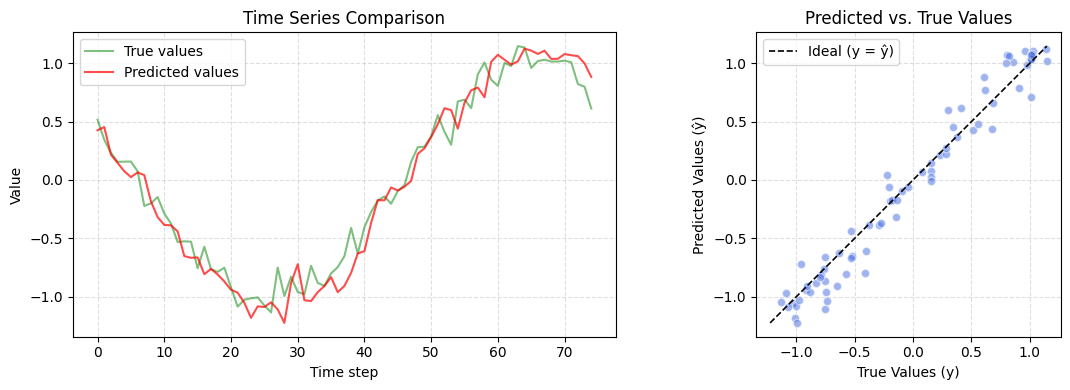

In [67]:
# Generate predictions
y_pred = model.predict(X_test)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# --- (1) Time series comparison ---
axes[0].plot(y_test, color="green", alpha=0.5, label="True values")
axes[0].plot(y_pred, color="red", alpha=0.7, label="Predicted values")
axes[0].set_title("Time Series Comparison")
axes[0].set_xlabel("Time step")
axes[0].set_ylabel("Value")
axes[0].legend()
axes[0].grid(True, linestyle="--", alpha=0.4)

# --- (2) Scatter plot with 45° reference line ---
axes[1].scatter(y_test, y_pred, alpha=0.5, color="royalblue", edgecolor="white")
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
axes[1].plot([min_val, max_val], [min_val, max_val],
             color="black", linestyle="--", linewidth=1.2, label="Ideal (y = ŷ)")
axes[1].set_title("Predicted vs. True Values")
axes[1].set_xlabel("True Values (y)")
axes[1].set_ylabel("Predicted Values (ŷ)")
axes[1].legend()
axes[1].grid(True, linestyle="--", alpha=0.4)
axes[1].set_aspect("equal")

plt.tight_layout()
plt.show()